<a href="https://colab.research.google.com/github/LielUziahu/L.Uziahu_Lab_Notebook-Mass_Lab/blob/master/Planulae_Release_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is to generate release plot for planulea acording to 2 morph and monn phase

importing moon phase

Starting Cell

In [39]:
import astral
from astral.moon import phase as moon_phase

def get_actual_moon_phase(date):
    """Calculates the actual moon phase for a given date using astral and maps it to a name."""
    # astral.moon.phase() returns a value from 0 to 29.53, where 0 is new moon
    # We map this value to common moon phase names.
    phase_value = moon_phase(date) # Pass the datetime object directly

    if 0 <= phase_value < 1.84: # New Moon: 0-1.84 days
        return 'New Moon'
    elif 1.84 <= phase_value < 5.53: # Waxing Crescent: 1.84-5.53 days
        return 'Waxing Crescent'
    elif 5.53 <= phase_value < 9.22: # First Quarter: 5.53-9.22 days
        return 'First Quarter'
    elif 9.22 <= phase_value < 13.0: # Waxing Gibbous: 9.22-13.0 days
        return 'Waxing Gibbous'
    elif 13.0 <= phase_value < 16.69: # Full Moon: 13.0-16.69 days
        return 'Full Moon'
    elif 16.69 <= phase_value < 20.38: # Waning Gibbous: 16.69-20.38 days
        return 'Waning Gibbous'
    elif 20.38 <= phase_value < 24.07: # Last Quarter: 20.38-24.07 days
        return 'Last Quarter'
    elif 24.07 <= phase_value <= 29.53: # Waning Crescent: 24.07-29.53 days (back to new moon)
        return 'Waning Crescent'
    else:
        return 'Unknown Phase' # Fallback for unexpected values

# Apply the actual moon phase function to update the 'Moon_Phase' column
plot_df['Moon_Phase'] = plot_df['Middle_Date'].apply(get_actual_moon_phase)

print(plot_df.head())

        Date     HF     NF Middle_Date       Moon_Phase  \
0 2024-03-01    0.0    0.0  2024-03-03     Last Quarter   
1 2024-03-05   30.0    9.0  2024-03-07  Waning Crescent   
2 2024-03-09   60.0    7.0  2024-03-11         New Moon   
3 2024-03-13   44.0   12.0  2024-03-15  Waxing Crescent   
4 2024-03-17  179.0  135.0  2024-03-19    First Quarter   

                    Custom_Label  
0  01/03\nMoon Phase Placeholder  
1  05/03\nMoon Phase Placeholder  
2  09/03\nMoon Phase Placeholder  
3  13/03\nMoon Phase Placeholder  
4  17/03\nMoon Phase Placeholder  


Generating moon phase images in PNG

In [65]:
# moon_pngs.py
# Generates ONLY PNG moon-phase images (no SVG)
# Correct phase geometry:
# - Dark part = black disk
# - Lit part = yellow + subtle texture
# - Transparent background
# - Quarters handled explicitly

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
OUT_DIR = Path("moon_pngs")
SIZE_PX = 256          # output size in pixels
DPI = 600              # matplotlib dpi; figsize is computed from SIZE_PX/DPI
FIELD_RES = 900        # internal render resolution for smooth edges (higher = smoother)
R = 1.0                # moon radius in normalized coordinates

# Yellow color (base) + texture modulation
YELLOW_RGB = np.array([1.0, 0.92, 0.25])  # warm yellow

# Texture tuning
TEXTURE_FREQ = 2.2       # lower = bigger craters/features
TEXTURE_STRENGTH = 0.18  # 0.10–0.30 typical

# Phases: (filename, illumination fraction, waning?)
PHASES = [
    ("new_moon",         0.00, False),
    ("waxing_crescent",  0.25, False),
    ("first_quarter",    0.50, False),
    ("waxing_gibbous",   0.75, False),
    ("full_moon",        1.00, False),
    ("waning_gibbous",   0.75, True),
    ("last_quarter",     0.50, True),
    ("waning_crescent",  0.25, True),
]


# =========================
# CORE GEOMETRY (FIXED)
# =========================
def lit_mask(X: np.ndarray, Y: np.ndarray, illum: float, waning: bool) -> np.ndarray:
    """
    Returns boolean mask for illuminated region.

    Model:
    - Always inside the moon disk: x^2 + y^2 <= R^2
    - For crescents/gibbous (illum != 0.5): illuminated = disk \ shifted_disk
      where shifted_disk is circle radius R centered at (dx, 0)
    - For quarters: illuminated is half-disk (x>=0 for waxing, x<=0 for waning)
    - new/full handled outside
    """
    inside_moon = (X * X + Y * Y) <= (R * R)

    # Quarter (special-case, otherwise degeneracy)
    if abs(illum - 0.5) < 1e-12:
        if waning:
            return inside_moon & (X <= 0.0)   # left half lit
        else:
            return inside_moon & (X >= 0.0)   # right half lit

    # Shift for terminator construction (matches the SVG approach)
    # illum=0.25 -> dx= +0.5R (waxing crescent)
    # illum=0.75 -> dx= -0.5R (waxing gibbous)
    dx = (1.0 - 2.0 * illum) * R
    if waning:
        dx = -dx  # mirror for waning

    inside_shifted = ((X - dx) ** 2 + (Y ** 2)) <= (R * R)

    # illuminated = moon disk MINUS shifted disk
    return inside_moon & (~inside_shifted)


def texture_field(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Simple crater-like procedural texture (smooth low-frequency variation).
    Returns values roughly in [-1, 1].
    """
    # A few blended sinusoids gives a "crater-ish" look without extra deps
    t = (
        0.55 * np.sin(TEXTURE_FREQ * X + 0.7) * np.sin(TEXTURE_FREQ * Y - 0.2) +
        0.30 * np.sin(1.6 * TEXTURE_FREQ * (X + 0.3)) * np.sin(1.3 * TEXTURE_FREQ * (Y - 0.1)) +
        0.15 * np.sin(2.2 * TEXTURE_FREQ * (X - 0.15) + 0.4)
    )
    # Normalize-ish
    return np.clip(t, -1.0, 1.0)


# =========================
# RENDERING
# =========================
def render_phase_png(name: str, illum: float, waning: bool) -> None:
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    # Create coordinate grid
    xs = np.linspace(-R, R, FIELD_RES)
    ys = np.linspace(-R, R, FIELD_RES)
    X, Y = np.meshgrid(xs, ys)

    inside_moon = (X * X + Y * Y) <= (R * R)

    # Base RGBA image (transparent)
    img = np.zeros((FIELD_RES, FIELD_RES, 4), dtype=np.float32)

    # Paint black disk (moon body)
    img[..., 3] = 0.0
    img[inside_moon, 0:3] = (0.0, 0.0, 0.0)
    img[inside_moon, 3] = 1.0

    # Add illuminated part
    if illum >= 1.0 - 1e-12:
        lit = inside_moon  # full moon
    elif illum <= 0.0 + 1e-12:
        lit = np.zeros_like(inside_moon, dtype=bool)  # new moon
    else:
        lit = lit_mask(X, Y, illum, waning)

    if np.any(lit):
        tex = texture_field(X, Y)
        # Apply texture as brightness modulation
        # clamp to keep color valid
        mod = np.clip(1.0 + TEXTURE_STRENGTH * tex, 0.75, 1.25)

        rgb = (YELLOW_RGB[None, None, :] * mod[..., None]).clip(0.0, 1.0)

        img[lit, 0:3] = rgb[lit]
        img[lit, 3] = 1.0  # keep opaque on lit pixels

    # Save via matplotlib (keeps transparency)
    fig = plt.figure(figsize=(SIZE_PX / DPI, SIZE_PX / DPI), dpi=DPI)
    ax = plt.axes([0, 0, 1, 1])
    ax.axis("off")

    ax.imshow(img, extent=(-R, R, -R, R), origin="lower", interpolation="bilinear")
    out_path = OUT_DIR / f"{name}.png"
    plt.savefig(out_path, transparent=True, dpi=DPI)
    plt.close(fig)


def main():
    for name, illum, waning in PHASES:
        render_phase_png(name, illum, waning)

    print(f"✅ Generated {len(PHASES)} PNGs in: {OUT_DIR.resolve()}")
    print("Files:")
    for name, _, _ in PHASES:
        print(f" - {OUT_DIR / (name + '.png')}")


if __name__ == "__main__":
    main()


<>:51: SyntaxWarning: invalid escape sequence '\ '
<>:51: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4277586797.py:51: SyntaxWarning: invalid escape sequence '\ '
  - For crescents/gibbous (illum != 0.5): illuminated = disk \ shifted_disk


✅ Generated 8 PNGs in: /content/moon_pngs
Files:
 - moon_pngs/new_moon.png
 - moon_pngs/waxing_crescent.png
 - moon_pngs/first_quarter.png
 - moon_pngs/waxing_gibbous.png
 - moon_pngs/full_moon.png
 - moon_pngs/waning_gibbous.png
 - moon_pngs/last_quarter.png
 - moon_pngs/waning_crescent.png


creating moon phase place holder

In [57]:
def get_moon_phase_placeholder(date):
    """Placeholder function for moon phase. Always returns 'Moon Phase Placeholder'."""
    return 'Moon Phase Placeholder'

# Apply the placeholder function to create a new 'Moon_Phase' column
plot_df['Moon_Phase'] = plot_df['Middle_Date'].apply(get_moon_phase_placeholder)

print(plot_df.head())

        Date     HF     NF Middle_Date              Moon_Phase  \
0 2024-03-01    0.0    0.0  2024-03-03  Moon Phase Placeholder   
1 2024-03-05   30.0    9.0  2024-03-07  Moon Phase Placeholder   
2 2024-03-09   60.0    7.0  2024-03-11  Moon Phase Placeholder   
3 2024-03-13   44.0   12.0  2024-03-15  Moon Phase Placeholder   
4 2024-03-17  179.0  135.0  2024-03-19  Moon Phase Placeholder   

              Custom_Label  
0     01/03\nLast\nQuarter  
1  05/03\nWaning\nCrescent  
2         09/03\nNew\nMoon  
3  13/03\nWaxing\nCrescent  
4    17/03\nFirst\nQuarter  


generating plot with moon phase

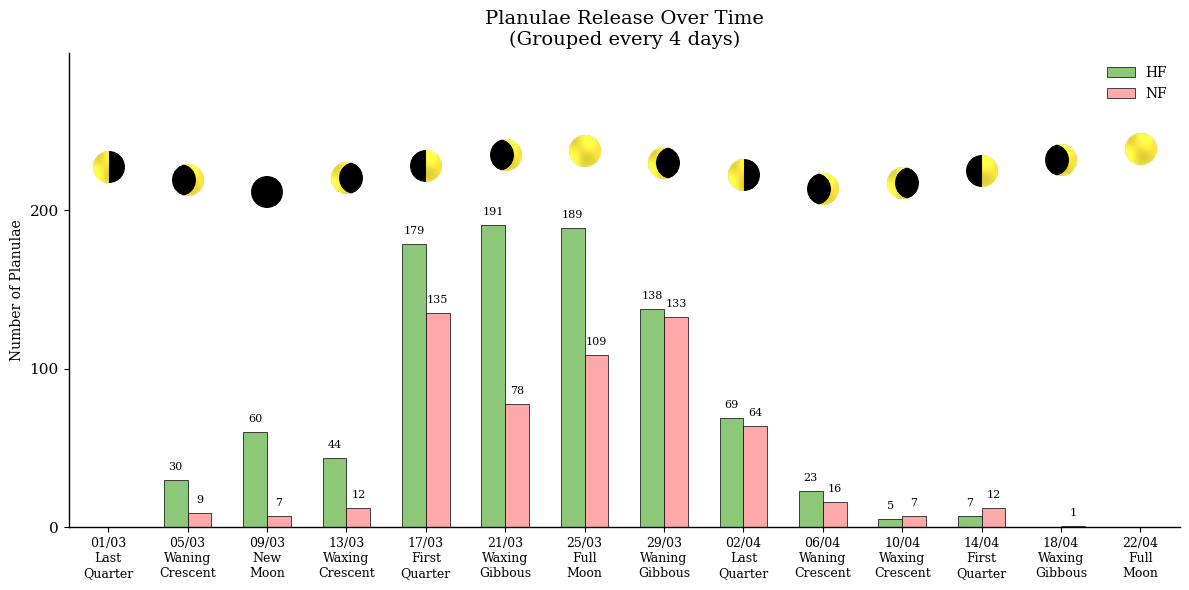

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from PIL import Image

# ==============================
# 1) LOAD + CLEAN DATA
# ==============================
df = pd.read_csv('Planulae_Release_by_moon.csv', skiprows=1)

green_cols = [col for col in df.columns if 'Green' in col and 'Half' not in col]
brown_cols = [col for col in df.columns if 'Brown' in col]

plot_df = pd.DataFrame()
plot_df['Date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

plot_df['HF'] = (
    df[green_cols]
    .fillna(0)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .sum(axis=1)
)

plot_df['NF'] = (
    df[brown_cols]
    .fillna(0)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .sum(axis=1)
)

plot_df.dropna(subset=['Date'], inplace=True)
plot_df = plot_df.sort_values('Date')

# Full date range
start_date_full = pd.to_datetime('01/03/2024', dayfirst=True)
end_date_full   = pd.to_datetime('22/04/2024', dayfirst=True)
full_date_range = pd.date_range(start=start_date_full, end=end_date_full, freq='D')

# Reindex & group every 4 days
plot_df = plot_df.set_index('Date')
plot_df = plot_df.reindex(full_date_range, fill_value=0)
plot_df.index.name = 'Date'
plot_df = plot_df.reset_index().set_index('Date').resample('4D').sum().reset_index()

# Middle date for moon phase labeling
plot_df['Middle_Date'] = plot_df['Date'] + pd.Timedelta(days=2)

# ==============================
# 2) MOON PHASE (Astral)
# ==============================
from astral.moon import phase as moon_phase

def get_actual_moon_phase_label(date):
    """Returns a label like 'Waxing\nCrescent' based on astral phase value."""
    pv = moon_phase(date)  # 0..29.53

    if 0 <= pv < 1.84:
        return 'New\nMoon'
    elif 1.84 <= pv < 5.53:
        return 'Waxing\nCrescent'
    elif 5.53 <= pv < 9.53:
        return 'First\nQuarter'
    elif 9.53 <= pv < 13.0:
        return 'Waxing\nGibbous'
    elif 13.0 <= pv < 16.69:
        return 'Full\nMoon'
    elif 16.69 <= pv < 20.38:
        return 'Waning\nGibbous'
    elif 20.38 <= pv < 24.07:
        return 'Last\nQuarter'
    elif 24.07 <= pv <= 29.53:
        return 'Waning\nCrescent'
    else:
        return 'Unknown\nPhase'

# label for filenames + x tick text
plot_df['Moon_Phase'] = plot_df['Middle_Date'].apply(get_actual_moon_phase_label)

# numeric phase for continuous y-position mapping
plot_df['Moon_Phase_Value'] = plot_df['Middle_Date'].apply(moon_phase)

# illumination fraction: 0 at new, 1 at full, back to 0 at new
cycle = 29.53
half_cycle = cycle / 2
plot_df['Illum_Frac'] = plot_df['Moon_Phase_Value'].apply(
    lambda pv: pv / half_cycle if pv <= half_cycle else (cycle - pv) / half_cycle
)

# x tick label
plot_df['Custom_Label'] = plot_df['Date'].dt.strftime('%d/%m') + '\n' + plot_df['Moon_Phase']

# ==============================
# 3) STYLING
# ==============================
plt.rcParams.update({
    'font.family': 'serif',
    'axes.edgecolor': 'black', 'axes.linewidth': 1,
    'xtick.color': 'black', 'ytick.color': 'black',
    'text.color': 'black', 'axes.labelcolor': 'black',
    'legend.frameon': False,
    'ytick.labelsize': 11,
    'xtick.labelsize': 9 # Changed from 11 to 9 for smaller font
})

variant_colors = {'HF': '#8cc878', 'NF': '#fea9a9'}

# ==============================
# 4) LOAD + PLACE MOON PNGs (FIXED SIZE + VARIABLE Y)
# ==============================
PNG_DIR = Path('moon_pngs')  # must contain: new_moon.png, waxing_crescent.png, etc.
_moon_cache = {}

def load_moon_image(moon_phase_name: str, target_px: int = 56) -> Image.Image:
    """Load a moon PNG and resize to a fixed pixel size (prevents huge icons)."""
    key = (moon_phase_name, target_px)
    if key in _moon_cache:
        return _moon_cache[key]

    png_filename = moon_phase_name.replace('\n', '_').lower() + '.png'
    png_path = PNG_DIR / png_filename

    if not png_path.exists():
        print(f"Warning: PNG not found for phase '{moon_phase_name}' at {png_path}")
        img = Image.new('RGBA', (target_px, target_px), (0, 0, 0, 0))
        _moon_cache[key] = img
        return img

    img = Image.open(png_path).convert("RGBA")
    img = img.resize((target_px, target_px), resample=Image.Resampling.LANCZOS)
    _moon_cache[key] = img
    return img

def place_moon_image(ax: plt.Axes, x_date, img: Image.Image, y_axes: float, zoom: float = 1.0):
    """
    Place image with x in data coords (datetime) and y in axes-fraction.
    """
    oi = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(
        oi,
        (x_date, y_axes),
        xycoords=('data', 'axes fraction'),
        frameon=False,
        pad=0
    )
    ax.add_artist(ab)

# Map illumination -> y position
Y_NEW  = 0.70
Y_FULL = 0.80
def y_from_illum(illum: float) -> float:
    return Y_NEW + (Y_FULL - Y_NEW) * float(illum)

# ==============================
# 5) PLOT
# ==============================
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 1.2  # days

# Plot HF bars and add labels
hf_bars = ax.bar(plot_df['Date'] - pd.Timedelta(days=bar_width/2), plot_df['HF'],
       color=variant_colors['HF'], label='HF', width=bar_width,
       alpha=1, edgecolor='black', linewidth=0.5)
for bar in hf_bars:
    yval = bar.get_height()
    if yval > 0: # Only label non-zero bars
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=8)

# Plot NF bars and add labels
nf_bars = ax.bar(plot_df['Date'] + pd.Timedelta(days=bar_width/2), plot_df['NF'],
       color=variant_colors['NF'], label='NF', width=bar_width,
       alpha=1, edgecolor='black', linewidth=0.5)
for bar in nf_bars:
    yval = bar.get_height()
    if yval > 0: # Only label non-zero bars
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=8)

ax.set_title('Planulae Release Over Time\n(Grouped every 4 days)', fontsize=14)
ax.set_ylabel('Number of Planulae')
ax.legend()

# x limits padding
start_date = plot_df['Date'].min() - pd.Timedelta(days=2)
end_date   = plot_df['Date'].max() + pd.Timedelta(days=2)
ax.set_xlim(start_date, end_date)

# y limits/ticks (bars)
ax.set_ylim(top=299) # Adjusted top limit to accommodate labels
plt.yticks(range(0, 299, 100))

# x ticks/labels
ax.set_xticks(plot_df['Date'])
ax.set_xticklabels(plot_df['Custom_Label'], rotation=0, ha='center')

# --- Place moons: size fixed, Y varies with illumination ---
MOON_PX = 56
MOON_ZOOM = 0.4

for _, row in plot_df.iterrows():
    moon_img = load_moon_image(row['Moon_Phase'], target_px=MOON_PX)
    y_axes = y_from_illum(row['Illum_Frac'])
    place_moon_image(ax, row['Date'], moon_img, y_axes=y_axes, zoom=MOON_ZOOM)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('Planulae_Release_Plot.png', dpi=600)
plt.show()